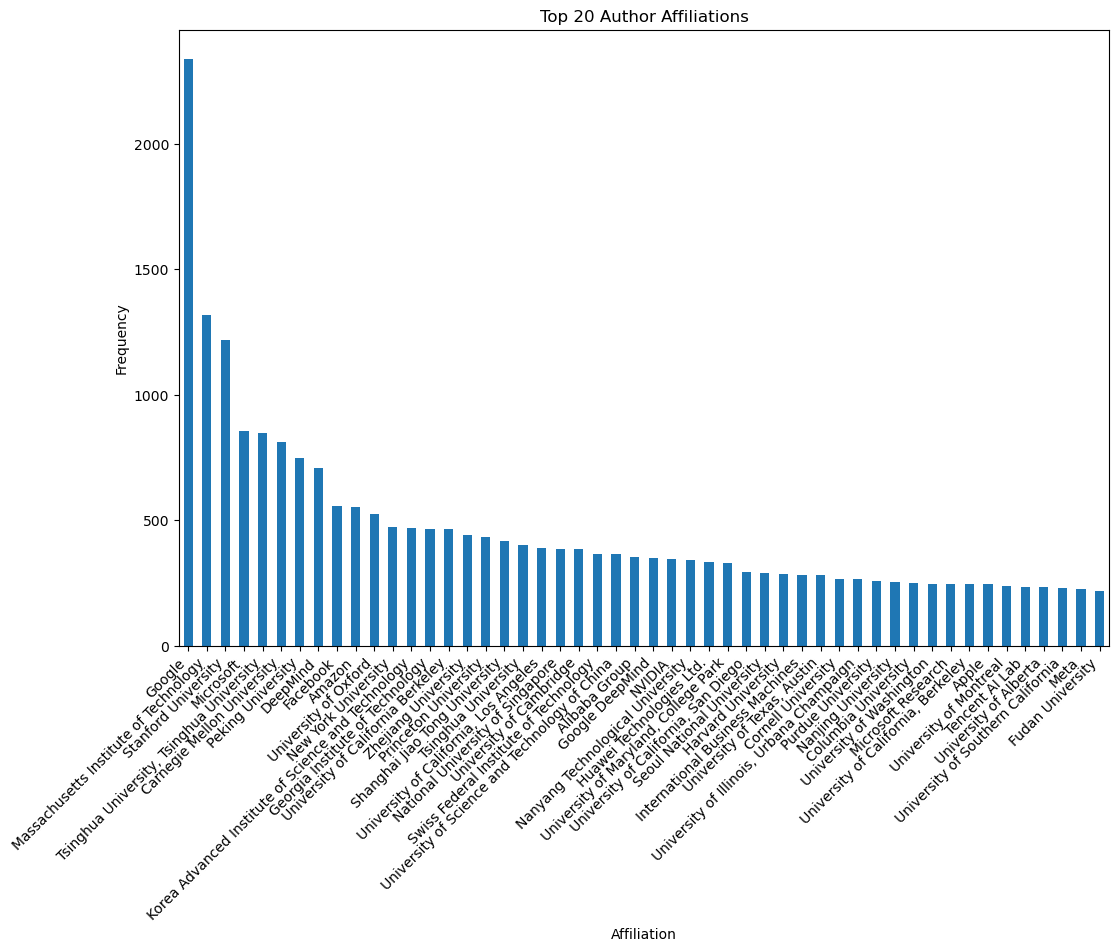

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the author dataset
authors_df = pd.read_csv('./dataset/gathered_author.csv')

# Count the frequency of each affiliation and get top 20
top_affiliations = authors_df['author_affiliation'].value_counts().head(50)

# Plotting the distribution of top 20 author affiliations
plt.figure(figsize=(12, 8))
top_affiliations.plot(kind='bar')
plt.title('Top 20 Author Affiliations')
plt.xlabel('Affiliation')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.show()


* 학계 top-20, 기업 top-20 에 해당하는 authors만 남기기 

In [2]:
def make_top_k_dataset(k):
    print('Before processing : ',len(authors_df))

    # Filter authors by affiliation type 0 and get top 20 affiliations
    top_20_affiliations_type_0 = authors_df[authors_df['author_affiliation_type'] == 0]['author_affiliation'].value_counts().head(k).index

    # Filter authors by affiliation type 1 and get top 20 affiliations
    top_20_affiliations_type_1 = authors_df[authors_df['author_affiliation_type'] == 1]['author_affiliation'].value_counts().head(k).index

    # Combine the top 20 affiliations for both types
    combined_top_affiliations = top_20_affiliations_type_0.union(top_20_affiliations_type_1)

    # Filter the authors to only include those whose affiliation is in the combined top 20 for both types
    filtered_authors_top_k_df = authors_df[authors_df['author_affiliation'].isin(combined_top_affiliations)]

    # Display the first few rows of the filtered dataframe
    filtered_authors_top_k_df.head()
    print('After processing : ', len(filtered_authors_top_k_df))
    
    # Plotting the distribution of top 20 author affiliations
    # top_affiliations = authors_df['author_affiliation'].value_counts().head(50)
    vis_filtered_authors = filtered_authors_top_k_df['author_affiliation'].value_counts()
    plt.figure(figsize=(12, 8))
    vis_filtered_authors.plot(kind='bar')
    plt.title('Top 20 Author Affiliations')
    plt.xlabel('Affiliation')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45, ha='right')
    plt.show()
    
    
    # Load the paper dataset
    papers_df = pd.read_csv('./dataset/gathered_paper.csv')
    print("Before processing : ", len(papers_df))

    # Get the unique paper IDs from the filtered authors dataset
    unique_paper_ids = filtered_authors_top_k_df['paper_id'].unique()

    # Filter the papers to only include those whose paper IDs are in the filtered authors dataset
    filtered_papers_df = papers_df[papers_df['paper_id'].isin(unique_paper_ids)]

    # Display the first few rows of the filtered papers dataframe
    # filtered_papers_df.head()
    print("After processing : ", len(filtered_papers_df))
    
    
    filtered_authors_top_k_df.to_csv(f"./dataset/{k}_processed_authors.csv")
    filtered_papers_df.to_csv(f"./dataset/{k}_processed_papers.csv")

이제 top_20_df에 없는 paper_id를 가지고 있는 paper들을 gathered_paper.csv에서 지울 예정.

처리된 author, paper dataframe을 csv로 바꿔줄 예정.

Before processing :  54819
After processing :  9956


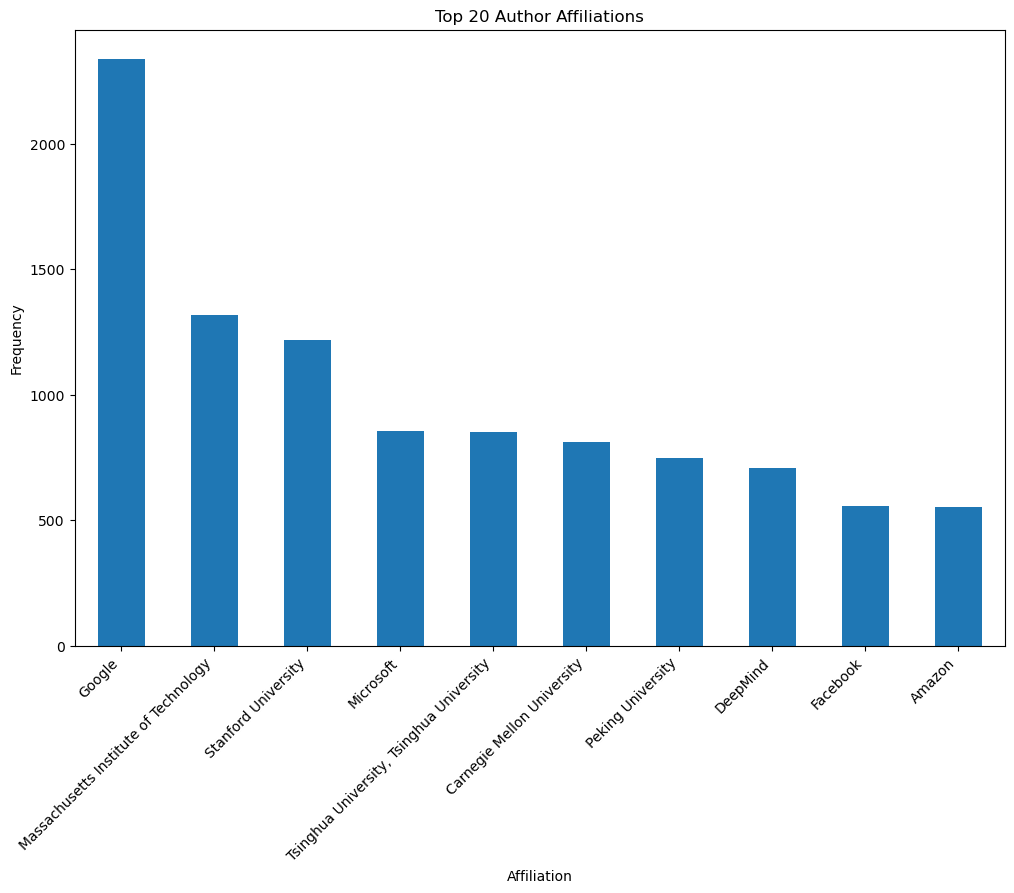

Before processing :  12873
After processing :  4537


In [4]:
k=5
make_top_k_dataset(5)